# **Quantum Key Distribution with the E91 Protocol**
---

## **Introduction** 
This project extends your work in Week 8 to implement a more advanced Quantum Key Distribution protocol relying upon quantum entanglement: the E91 Protocol. Proposed just 7 years after the BB84 protocol by Artur K. Ekert, this protocol is a strong candidate for securing the quantum and maybe even classical internets of the future. It is particularly powerful because Alice and Bob only need public classical channels and shared Bell pairs whereas BB84 and others also require quantum channels.

<br>

## **Description**
E91 can be broken down into the following steps:

**Phase 1**: Alice Makes Choices and Measures

> **Step 1**: Alice and Bob share a Bell pair.
>
> **Step 2**: Alice randomly chooses 1 of 3 circuits to apply to each of her qubits.
>
> **Step 3**: Alice measures her qubits.

**Phase 2**: Bob Makes Choices and Measures

> **Step 4**: Bob randomly chooses 1 or 3 circuits to apply to each of his qubits.
>
> **Step 5**: Bob measures his qubits.

**Phase 3**: Alice and Bob Compare Choices

> **Step 6**: Alice and Bob compare choices, sorting into two groups:
1. *Matching choices*: Alice and Bob each create their own key from these.
1. *Mismatching choices*: Alice and Bob tell each other their measurement results and test how entangled they were. If Eve has intercepted, the entanglement between Alice and Bob will be less than expected.


<br>

The core ideas behind this protocol are:
* Alice and Bob share maximally entangled qubits to start (Step #1). In practice, this could be implemented using Quantum Repeaters so that Alice and Bob actually never have to meeting for the protocol.
* If Eve intercepts in any way, she will destroy some or all of the entanglement due to the effect of measurement.
* Alice and Bob can determine how much entanglement they have in the end (Step #6), so they can tell if Eve destroyed some or not.
* Alice and Bob only have to communicate classically (Step #6). They never have to send quantum information to each other or even use secure private channels.


<br>

## **Key Questions**
In this project, you will answer the following questions:

1. How does Eve's interception change the amount of entanglement Alice and Bob share? Why?

1. Imagine that Eve attempts to go unnoticed by preparing Alice and Bob's qubits back into the $|\beta_{11}\rangle$ state instead of whatever her measurement results were. Answer these two questions based on this scenario:
  * Would this accomplish Eve's goal of going unnoticed? **Hint**: Think about how the entanglement would or would not change in this case. Consider writing code to test this.
  * Why does this still keep Eve from learning Alice's and Bob's key?

1. In BB84, Alice decides the key at the very beginning and tries communicating it to Bob securely. That is not the case in E91. *When* in the protocol is the key officially created? **Hint**: It's before Alice and Bob actually create their keys.

<br>

## **Structure**
This project is broken into 3 parts:
> **Part 1**: E91 Protocol for One Qubit
>
>> **Part 1.1**: Phase 1 - Alice Makes Choices and Measures
>>
>> **Part 1.2**: Phase 2 - Bob Makes Choices and Measures
>>
>> **Part 1.3**: Phase 3 - Alice and Bob Compare Choices
>
> **Part 2**: E91 Protocol for Multiple Qubits
>
> **Part 3**: Eve Intercepts!
>
> **Wrapping Up**



<br>

## **Resources**
* [Week 8 Lab Solutions (BB84)](https://drive.google.com/file/d/1S-zNslzmNRtH2-sr024ykRueRRwCgb6M/view?usp=share_link)
* [Qiskit Documentation: Z Rotation Gate](https://qiskit.org/documentation/stubs/qiskit.circuit.library.RZGate.html)
* [Youtube: High Level Description of E91 Protocol by Artur Ekert Himself](https://www.youtube.com/watch?v=TyomwLbYhig)
* [Quantum Cryptography Based on Bell's Theorem](http://www.physics.drexel.edu/~bob/Entanglement/Ekert_keydistribution.pdf): The original paper by Artur Ekert proposing this protocol in 1991
* [QuTech Quantum Network Simulator: E91 Protocol](https://www.quantum-network.com/applications/5/)

<br>

**These resources aren't necessary for completing this project, but are provided in case you are curious about the way that entanglement is being tested.**
* [Qiskit Textbook: Local Reality and the CHSH Inequality](https://qiskit.org/textbook/ch-demos/chsh.html)
* [Wikipedia: CHSH Inequality](https://en.wikipedia.org/wiki/CHSH_inequality)
* [Wikipedia: Bell's Theorem](https://en.wikipedia.org/wiki/Bell%27s_theorem)

---

## **Part 0: Importing from Qiskit**
---

**Run the code below to import everything needed for this lab.**

In [1]:
#!pip install qiskit

from qiskit import QuantumCircuit, Aer, transpile, assemble, execute, IBMQ
from qiskit.visualization import plot_histogram

import numpy as np
import random
import math

import warnings
warnings.filterwarnings('ignore')


# Determine the amount of entanglement between these bits using the CHSH value
def entanglement_amount(alice_choices, alice_bits, bob_choices, bob_bits):
    
  # count the different measurement results
  # rows correspond to Alice and Bob's circuit choices: 00, 02, 20, 22
  # NOTE: We do not consider circuits 1 or 3 for this test
  # columns correspond to Alice and Bob's qubit measurements: 00, 01, 10, and 11
  circuits = {'00': 0, '02': 1, '20': 2, '22': 3}
  counts = [[0]*4 for i in range(4)]
  for i in range(len(alice_choices)):
    circuit = str(alice_choices[i]) + str(bob_choices[i])
    state = int(alice_bits[i]) + 2*int(bob_bits[i])

    if circuit in circuits: counts[circuits[circuit]][state] += 1


  # expectation values calculated by 
  # adding times Alice and Bob's bits agreed and
  # subtracting times Alice and Bob's bits disagreed
  expectations = []

  for circuit in range(4):
    expectations += [counts[circuit][0] + counts[circuit][3] - counts[circuit][1] - counts[circuit][2]]
    total = sum(counts[circuit])

    if total != 0: expectations[circuit] /= total


  # returning CHSH correlation
  return expectations[0] - expectations[1] + expectations[2] + expectations[3]
  

print("Libraries Imported Successfully!")

Libraries Imported Successfully!


## **Part 1: E91 Protocol for One Qubit**
---

In this section, we will build up the E91 protocol as follows:

**Part 1.1**: Phase 1 - Alice Makes Choices and Measures

**Part 1.2**: Phase 2 - Bob Makes Choices and Measures

**Part 1.3**: Phase 3 - Alice and Bob Compare Choices


<br>

**Disclaimer**: This section is about building up the components and not about understanding the protocol yet. Realistically, the protocol would never be run for just one qubit and some of the results may even be hard to understand in this case. So, do not worry if you are unsure what results to expect by the end of this part and instead focus on implementing each step according to the instructions. In Parts 2 - 3, you will begin to understand the protocol much more in depth.

---
### **Part 1.1: Phase 1 - Makes Choices and Measures**


In this section, we will implement the first 3 steps of the protocol:

> **Step 1**: Alice and Bob share a Bell pair.
>
> **Step 2**: Alice randomly chooses 1 of 3 circuits to apply to each of her qubits.
>
> **Step 3**: Alice measures her qubits.

#### **Step #1: Alice and Bob share a Bell pair.**

We will use the Bell pair: $|\beta_{11}\rangle = \frac{1}{\sqrt 2}(|01\rangle - |10\rangle) = X_0 Z_0 |\beta_{00}\rangle$. We will consider $q_0$ as Alice's qubit and $q_1$ as Bob's qubit for the remainder of the protocol.

**Complete the code below to prepare this state.**

<br>

**NOTE**: The $|\beta_{00}\rangle$ state would work too, but $|\beta_{11}\rangle$ happens to simplify the circuits in the end.

In [2]:
alice_bob_qubits = QuantumCircuit(2, 2)

alice_bob_qubits.h(0)
alice_bob_qubits.cx(0,1)
alice_bob_qubits.x(0)
alice_bob_qubits.z(0)

alice_bob_qubits.draw()

┌───┐     ┌───┐┌───┐
q_0: ┤ H ├──■──┤ X ├┤ Z ├
     └───┘┌─┴─┐└───┘└───┘
q_1: ─────┤ X ├──────────
          └───┘          
c_0: ════════════════════
                         
c_1: ════════════════════

#### **Step #2: Alice randomly chooses 1 of 3 circuits to apply to each of her qubits.**

The E91 protocol introduces a slightly different set of options for Alice. They all follow the same format: Rotate around the Z axis by some amount and apply an H gate.  

In this step, we will define the three circuits and choose one at random as follows:

1. Define the 0 Rotation and H Gate Option.
2. Define the $\frac{\pi}{4}$ (45°) Rotation and H Gate Option.
3. Define the $\frac{\pi}{2}$ (90°) Rotation and H Gate Option.
4. Alice chooses at random.

<br>

**NOTE**: There is nothing special about these exact three choices from a quantum mechanical standpoint. But, they are the choices originally proposed by Ekert as the rotation gates are relatively simple to understand when looked at on a Bloch sphere. At the end of the day, if they were good enough for him then they're good enough for us!

##### **1. Define the 0 Rotation and H Gate Option.**

**Run the code below to create this circuit with 1 qubit and 1 classical bit for Alice's measurement.**

In [3]:
alice_option_1 = QuantumCircuit(1, 1)

alice_option_1.rz(0,0)

alice_option_1.h(0)

alice_option_1.measure(0, 0)

##### **2. Define the $\frac{\pi}{4}$ (45°) Rotation and H Gate Option.**

In [4]:
alice_option_2 = QuantumCircuit(1, 1)

alice_option_2.rz(math.pi/4,0)  # COMPLETE THIS LINE

alice_option_2.h(0)

alice_option_2.measure(0, 0)

##### **3. Define the $\frac{\pi}{2}$ (90°) Rotation and H Gate Option.**

In [5]:
alice_option_3 = QuantumCircuit(1, 1)

alice_option_3.rz(math.pi/2,0)   # COMPLETE THIS LINE

alice_option_3.h(0)

alice_option_3.measure(0, 0)

##### **4. Alice chooses at random.**

In [6]:
alice_options = [alice_option_1,alice_option_2,alice_option_3]       # COMPLETE THIS LINE WITH THE OTHER OPTIONS
alice_choice = random.randint(0, 2)

alice_circuit = alice_options[alice_choice]
alice_circuit.draw()

┌───────┐┌───┐┌─┐
q: ┤ Rz(0) ├┤ H ├┤M├
   └───────┘└───┘└╥┘
c: ═══════════════╩═

#### **Step 3: Alice measures her qubits.**

Lastly, Alice must use her randomly chosen circuit to measure her half of the Bell pair.


**Run the code below to perform this step.**

In [7]:
alice_bob_qubits = alice_bob_qubits.compose(alice_circuit, qubits = [0] , clbits = [0])

alice_bob_qubits.draw()

┌───┐     ┌───┐┌───┐┌───────┐┌───┐┌─┐
q_0: ┤ H ├──■──┤ X ├┤ Z ├┤ Rz(0) ├┤ H ├┤M├
     └───┘┌─┴─┐└───┘└───┘└───────┘└───┘└╥┘
q_1: ─────┤ X ├─────────────────────────╫─
          └───┘                         ║ 
c_0: ═══════════════════════════════════╩═
                                          
c_1: ═════════════════════════════════════

---

<center>

### **End of Phase 1**

</center>

---

---
### **Part 1.2:  Phase 2 - Makes Choices and Measures**


In this section, we will implement the next 2 steps of the protocol:

> **Step 4**: Bob randomly chooses 1 or 3 circuits to apply to each of his qubits.
>
> **Step 5**: Bob measures his qubits.

#### **Step #4: Bob randomly chooses 1 or 3 circuits to apply to each of his qubits.**

In this step, Bob chooses from his own set of circuits. Although they are of the same general form as Alice's (Z rotation and then H gate), they are different. As such, perform this step as follows:

1. Define the $\frac{\pi}{4}$ (45°) Rotation and H Gate Option.
2. Define the $\frac{\pi}{2}$ (90°) Rotation and H Gate Option.
3. Define the $\frac{3\pi}{4}$ (135°) Rotation and H Gate Option.
4. Bob chooses at random.

##### **1. Define the $\frac{\pi}{4}$ (45°) Rotation and H Gate Option.**

In [8]:
bob_option_1 = QuantumCircuit(1, 1)

bob_option_1.rz(math.pi/4,0)# COMPLETE THIS LINE
bob_option_1.h(0)           # COMPLETE THIS LINE

bob_option_1.measure(0, 0)

##### **2. Define the $\frac{\pi}{2}$ (90°) Rotation and H Gate Option.**

In [9]:
bob_option_2 = QuantumCircuit(1, 1)

bob_option_2.rz(math.pi/4,0)# COMPLETE THIS LINE

bob_option_2.h(0)           # COMPLETE THIS CODE

bob_option_2.measure(0, 0)

##### **3. Define the $\frac{3\pi}{4}$ (135°) Rotation and H Gate Option.**

In [10]:
bob_option_3= QuantumCircuit(1, 1) # COMPLETE THIS CODE

bob_option_3.rz(math.pi*3/4,0)

bob_option_3.h(0)

bob_option_3.measure(0, 0)

##### **4. Bob chooses at random.**

In [11]:
bob_options = [bob_option_1,bob_option_2,bob_option_3]# COMPLETE THIS LINE
bob_choice = random.randint(0, 2)

bob_circuit = bob_options[bob_choice]
bob_circuit.draw()

┌─────────┐┌───┐┌─┐
q: ┤ Rz(π/4) ├┤ H ├┤M├
   └─────────┘└───┘└╥┘
c: ═════════════════╩═

#### **Step 3: Bob measures his qubits.**

Lastly, Bob must use his randomly chosen circuit to measure his half of the Bell pair.


**Run the code below to perform this step.**

In [12]:
alice_bob_qubits = alice_bob_qubits.compose(bob_circuit, qubits = [1], clbits = [1])

alice_bob_qubits.draw()

┌───┐        ┌───┐   ┌───┐┌───────┐┌───┐┌─┐
q_0: ┤ H ├──■─────┤ X ├───┤ Z ├┤ Rz(0) ├┤ H ├┤M├
     └───┘┌─┴─┐┌──┴───┴──┐├───┤└──┬─┬──┘└───┘└╥┘
q_1: ─────┤ X ├┤ Rz(π/4) ├┤ H ├───┤M├─────────╫─
          └───┘└─────────┘└───┘   └╥┘         ║ 
c_0: ══════════════════════════════╬══════════╩═
                                   ║            
c_1: ══════════════════════════════╩════════════

#### **Simulate the Measurements Before Moving On.**

##### **Run the code below to simulate Alice's and Bob's measurement results.**

<br>


**Notice**: In the original state that Alice and Bob shared, $|\beta_{11} \rangle = \frac{1}{\sqrt 2}(|01\rangle - |10\rangle)$, their bits always had to be the opposite of each other. Unless they happened to rotate the qubits by the same amount, this is no longer true!

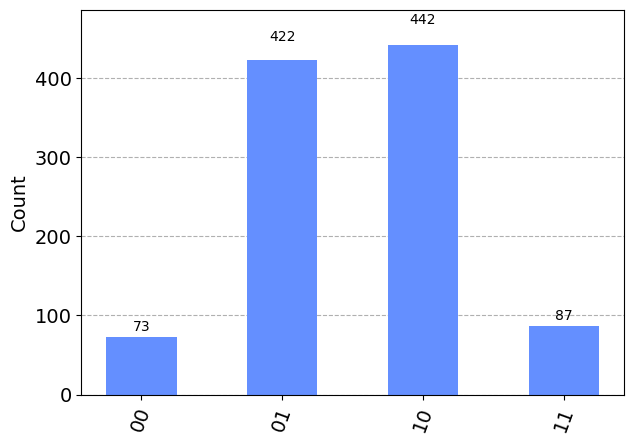

In [13]:
backend = Aer.get_backend('qasm_simulator')
job = execute(alice_bob_qubits, backend = backend, shots = 1024)


result = job.result()
counts = result.get_counts()

bits = random.choices(list(counts.keys()), weights = counts.values(), k = 1)[0]
alice_bits = bits[0]
bob_bits = bits[1]


plot_histogram(counts)

---

<center>

### **End of Phase 2**

</center>

---

---
### **Part 1.3: Phase 3 - Alice and Bob Compare Choices**


In this section, we will implement the last step of the protocol:

> **Step 6**: Alice and Bob compare choices, sorting into two groups:
1. *Matching choices*: Alice and Bob each create their own key from these.
1. *Mismatching choices*: Alice and Bob tell each other their measurement results and test how entangled they were. If Eve has intercepted, the entanglement between Alice and Bob will be less than expected.

#### **Step 6: Alice and Bob compare choices.**

Very importantly in this step, Alice and Bob are comparing the **circuits themselves**. So "matching choices" consist of:

* Alice's 2nd Option and Bob's 1st Option, both $\frac{\pi}{4}$ rotations.
* Alice's 3rd Option and Bob's 2nd Option, both $\frac{\pi}{2}$ rotations.

<br>


**Run the code below to perform this step.**


<br>

**NOTE**: Since we are only dealing with one qubit and no Eve interceptions, this will not produce particularly interesting results. The main goal here is for you to see how this step works in general so that you can understand it further in the following sections.

In [14]:
alice_key = []
alice_mismatched_choices = []
alice_mismatched_choice_bits = []

bob_key = []
bob_mismatched_choices = []
bob_mismatched_choice_bits = []


# MATCHING CHOICE
if alice_options[alice_choice] == bob_options[bob_choice]:
  alice_key += [int(alice_bits[0])]
  bob_key += [1 - int(bob_bits[0])]

# MISMATCHING CHOICE
else:
  alice_mismatched_choices += [alice_choice]
  bob_mismatched_choices += [bob_choice]

  alice_mismatched_choice_bits += [alice_bits[0]]
  bob_mismatched_choice_bits += [bob_bits[0]]


entanglement = entanglement_amount(alice_mismatched_choices, alice_mismatched_choice_bits, bob_mismatched_choices, bob_mismatched_choice_bits)
print("Entanglement of Mismatched Choices: " + str(entanglement))
print("Alice's Key: " + str(alice_key))
print("Bob's Key: " + str(bob_key))

Entanglement of Mismatched Choices: 0
Alice's Key: []
Bob's Key: []


**Before continuing**, review your work here and make sure you understand why the following happens:

1. If Alice and Bob make the same choice (apply the same circuit), then they keep the bit for their key.
1. Furthermore, when Alice and Bob keep a bit for their key, Bob flips his measurement result as shown in the code by `1 - int(bob_bits[0])`.
3. Could Alice flip her measurement result instead?

# RESPONSE
1.To ensure that key is secure, Alice and Bob must only use the measurement outcomes that are obtained when they use the same basis.In this case , we have 2 options for Alice and Bob to keep their measurement choices the same.
- Alice's 2nd Option and Bob's 1st Option, both pi/4 rotations.
- Alice's 3rd Option and Bob's 2nd Option, both pi/2 rotations.
- To understand , we have considered Alice and Bob's choice using Rz rotation with angle pi/2 followed by H.
- We can observe that by keeping their measurement choice options the same they are able to keep their key and there are no chances of the mismatched choices and entangle amount is zero.
- An important note to consider is that the selection of their bases decides the security of their key .
- In other words, if their choices are the same , the results of their measurements are kept secret which helps Alice and Bob to generate their keys.
- And if the choices are not the same, their results are public and used by CHSH in order to calculate the entanglement variation between the two.
- Alice and Bob only generates the key , when they have the same basis which results in the equal probability of |01> or |10> .If they use different bases than their measurement outcomes won't be correlated.By using only the outcomes that are correlated with each other, Alice and Bob can be confident that their key is secure and that any attempt by Eve to eavesdrop on their communication will be detected.


2.Alice and Bob prepare their entangled bell state beta11.
In the generated bell pair, qubit 0 is alice and qubit 1 is Bob. Hence, in the measurement outcome both Alice and Bob outcome are inverse of each other.
Hence when Alice has bit 0 then Bob will have bit 1 and vice versa. But the final secret key must be the same on both sides. Hence Bob flips his bit by doing 1-(bob_bit).


3.No, Alice cannot flip her measurement result in the E91 protocol. The E91 protocol relies on the principle of non-locality, which means that the measurement outcomes of Alice and Bob are correlated even though they are spatially separated. If Alice were to flip her measurement result, this would break the correlation and compromise the security of the protocol. Therefore, it is essential for Alice to report her measurement result honestly to ensure the security of the E91 protocol.

---

<center>

### **End of the Protocol**

</center>

---

## **Part 2: E91 Protocol for Multiple Qubits**
---

In this section, we will apply the components you developed in Part 1 to the full E91 protocol.

### **Exercise #1**

To make building the multiple qubit version of E91 easier, complete the code below with your solutions from above to see the protocol in full for one qubit.

<br>

**NOTE**: This is only including the key pieces that may need to be redefined for each run. For example, we do not need to redefine Alice's and Bob's different circuit options every time, but we do need to randomly pick a new one every time.

In [15]:
#========
# STEP 1
#========
alice_bob_qubits = QuantumCircuit(2, 2)
alice_bob_qubits.h(0)  
alice_bob_qubits.cx(0,1)
alice_bob_qubits.x(0)
alice_bob_qubits.z(0)
alice_bob_qubits.draw()



#========
# STEP 2
#========
alice_choice = random.randint(0, 2)

alice_circuit = alice_options[alice_choice]
alice_circuit.draw()

#========
# STEP 3
#========
alice_bob_qubits = alice_bob_qubits.compose(alice_circuit, qubits = [0], clbits = [0])


#========
# STEP 4
#========
bob_choice = random.randint(0, 2)
bob_circuit = bob_options[bob_choice]


#========
# STEP 5
#========
alice_bob_qubits = alice_bob_qubits.compose(bob_circuit, qubits = [1], clbits = [1])


#======================
# SIMULATE THE CIRCUIT
#======================
backend = Aer.get_backend('qasm_simulator')
job = execute(alice_bob_qubits, backend = backend, shots = 1024)
result = job.result()
counts = result.get_counts()

bits = random.choices(list(counts.keys()), weights = counts.values(), k = 1)[0]
alice_bits = bits[0]
bob_bits = bits[1]
plot_histogram(counts)


#========
# STEP 6
#========
alice_key = []
alice_mismatched_choices = []
alice_mismatched_choice_bits = []

bob_key = []
bob_mismatched_choices = []
bob_mismatched_choice_bits = []


# MATCHING CHOICE
if alice_options[alice_choice] == bob_options[bob_choice]:
  alice_key += [int(alice_bits[0])]
  bob_key += [1 - int(bob_bits[0])]

# MISMATCHING CHOICE
else:
    alice_mismatched_choices += [alice_choice]
    bob_mismatched_choices += [bob_choice]

    alice_mismatched_choice_bits += [alice_bits[0]]
    bob_mismatched_choice_bits += [bob_bits[0]]


entanglement = entanglement_amount(alice_mismatched_choices, alice_mismatched_choice_bits, bob_mismatched_choices, bob_mismatched_choice_bits)
print("Entanglement of Mismatched Choices: " + str(entanglement))
print("Alice's Key: " + str(alice_key))
print("Bob's Key: " + str(bob_key))

Entanglement of Mismatched Choices: 0
Alice's Key: []
Bob's Key: []


### **Exercise #2**

Modify each step to work for $n$ qubits instead of just $1$.

**Run the code below to define $n$ for this exercise.**

In [16]:
n = 100

#### **Step 1: Alice and Bob share a Bell pair.**

Now, they must share $n$ Bell pairs. Complete the code below to create $n$ circuits that each start by creating the $|\beta_{11}\rangle$ state.

In [17]:
alice_bob_qubits = []

for i in range(n):
    alice_bob_qubits += [QuantumCircuit(2,2)]

    alice_bob_qubits[i].h(0)    
    alice_bob_qubits[i].cx(0,1) 
    alice_bob_qubits[i].x(0)    
    alice_bob_qubits[i].z(0)    

#### **Step 2: Alice randomly chooses 1 of 3 circuits to apply to each of her qubits.**

In [18]:
alice_choices = []
alice_circuits = []

for i in range(n):                           
    alice_choices += [random.randint(0, 2)]
    alice_circuits += [alice_options[alice_choices[i]]] 

#### **Step 3: Alice measures her qubits.**

In [19]:
for i in range(100):                                      
    alice_bob_qubits[i] = alice_bob_qubits[i].compose(alice_circuit, qubits = [0] , clbits = [0])


#### **Step 4: Bob randomly chooses 1 of 3 circuits to apply to each of his qubits.**

In [20]:
bob_choices = []
bob_circuits = []

for i in range(n):                           
    bob_choices += [random.randint(0, 2)]
    bob_circuits += [bob_options[bob_choices[i]]]

#### **Step 5: Bob measures his qubits.**

In [21]:
for i in range(100):
    alice_bob_qubits[i] = alice_bob_qubits[i].compose(alice_circuit, qubits = [1] , clbits = [1])

#### **Simulate the Circuit**

In [22]:
backend = Aer.get_backend('qasm_simulator')
job = execute(alice_bob_qubits, backend = backend, shots = 1)
result = job.result()
counts = result.get_counts()

alice_bits = []
bob_bits = []
for i in range(n):
    bits = list(counts[i].keys())[0]
    alice_bits += [bits[0]]
    bob_bits += [bits[1]]

#### **Step 6: Alice and Bob compare choices.**

In [23]:
alice_key = []
alice_mismatched_choices = []
alice_mismatched_choice_bits = []

bob_key = []
bob_mismatched_choices = []
bob_mismatched_choice_bits = []

for i in range(n):

  # MATCHING CHOICE
  if alice_options[alice_choices[i]] == bob_options[bob_choices[i]]: 
    alice_key += [int(alice_bits[i])]
    bob_key += [1 - int(bob_bits[i])]

  # MISMATCHING CHOICE
  else:
    alice_mismatched_choices += [alice_choices[i]]
    bob_mismatched_choices += [bob_choices[i]] # COMPLETE THIS LINE

    alice_mismatched_choice_bits += [alice_bits[i]] # COMPLETE THIS LINE
    bob_mismatched_choice_bits +=  [bob_bits[i]]    # COMPLETE THIS LINE


entanglement = entanglement_amount(alice_mismatched_choices, alice_mismatched_choice_bits, bob_mismatched_choices, bob_mismatched_choice_bits)
print("Entanglement of Mismatched Choices: " + str(entanglement))
print("Alice's Key: " + str(alice_key))
print("Bob's Key: " + str(bob_key))
print("Key Length: " + str(len(bob_key)))
print("Number of Disagreeing Key Bits: " + str(sum([alice_key[i] != bob_key[i] for i in range(len(alice_key))])))

Entanglement of Mismatched Choices: -2.0
Alice's Key: [0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0]
Bob's Key: [0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0]
Key Length: 26
Number of Disagreeing Key Bits: 0


### **Exercise #3**

Similar to Exercise #1, put all the code for the $n$ qubit E91 protocol into one cell below.

In [24]:
#========
# STEP 1
#========
n = 100


#========
# STEP 2
#========
alice_bob_qubits = []

for i in range(n):
    alice_bob_qubits += [QuantumCircuit(2,2)]

    alice_bob_qubits[i].h(0)    
    alice_bob_qubits[i].cx(0,1) 
    alice_bob_qubits[i].x(0)    
    alice_bob_qubits[i].z(0)    


#========
# STEP 3
#========
alice_choices = []
alice_circuits = []

for i in range(n):                           
    alice_choices += [random.randint(0, 2)]
    alice_circuits += alice_options[alice_choice]       
for i in range(100):                                   
    alice_bob_qubits[i] = alice_bob_qubits[i].compose(alice_circuit, qubits = [0] , clbits = [0])

#========
# STEP 4
#========
bob_choices = []
bob_circuits = []

for i in range(n):                           
    bob_choices += [random.randint(0, 2)]
    bob_circuits += bob_options[bob_choice]


#========
# STEP 5
#========
for i in range(100):
    alice_bob_qubits[i] = alice_bob_qubits[i].compose(alice_circuit, qubits = [1] , clbits = [1])

#======================
# SIMULATE THE CIRCUIT
#======================
backend = Aer.get_backend('qasm_simulator')
job = execute(alice_bob_qubits, backend = backend, shots = 1)
result = job.result()
counts = result.get_counts()

alice_bits = []
bob_bits = []
for i in range(n):
    bits = list(counts[i].keys())[0]
    alice_bits += [bits[0]]
    bob_bits += [bits[1]]


#========
# STEP 6
#========
alice_key = []
alice_mismatched_choices = []
alice_mismatched_choice_bits = []

bob_key = []
bob_mismatched_choices = []
bob_mismatched_choice_bits = []

for i in range(n):

  # MATCHING CHOICE
  if alice_options[alice_choices[i]] == bob_options[bob_choices[i]]: 
    alice_key += [int(alice_bits[i])]
    bob_key += [1 - int(bob_bits[i])]

  # MISMATCHING CHOICE
  else:
    alice_mismatched_choices += [alice_choices[i]]
    bob_mismatched_choices += [bob_choices[i]] 

    alice_mismatched_choice_bits += [alice_bits[i]] 
    bob_mismatched_choice_bits +=  [bob_bits[i]]   


entanglement = entanglement_amount(alice_mismatched_choices, alice_mismatched_choice_bits, bob_mismatched_choices, bob_mismatched_choice_bits)
print("Entanglement of Mismatched Choices: " + str(entanglement))
print("Alice's Key: " + str(alice_key))
print("Bob's Key: " + str(bob_key))
print("Key Length: " + str(len(bob_key)))
print("Number of Disagreeing Key Bits: " + str(sum([alice_key[i] != bob_key[i] for i in range(len(alice_key))])))

Entanglement of Mismatched Choices: -2.0
Alice's Key: [0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0]
Bob's Key: [0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0]
Key Length: 19
Number of Disagreeing Key Bits: 0


### **Questions**

You have now implemented the full $n$ qubit E91 protocol without any interception. Before moving on, make sure you understand the answers to the following questions:

1. The average key length is $\frac{2}{9}n$. Why? **Hint**: Consider what needs to happen for bits to be included in the key and how many ways this can happen.

1. The amount of entanglement being reported says how Alice's and Bob's measurements are related. The more often their measurements agree (00 or 11), the more positive the entanglement gets. The more often their measurements disagree (01 or 10), the more negative the entanglement gets. What results are you tending to see above and why do they make sense?

<br>

**NOTE**: The theoretical amount of entanglement for *many* qubits is $-2\sqrt 2 \approx -2.8$, but it is unlikely that you would get exactly this amount.

# Response

1. Alice can measure in 3 bases (0,π/4,π/2) and Bob can measure in 3 bases (π/4,π/2,3π/4). In each iteration both bases are chosen randomly.Hence total possibilities for each iteration are 3x3=9.Out of these 9 possibilities there are only 2 possibilities when the measurement bases are same(Alice is π/4 and Bob is π/4 or Alice is π/2 and Bob is π/2) and only in these  possibilities the bits will be kept for key. Hence the probability of a bit being kept as key is 2/9. So for n bits the average key length is (2/9)n.

2.Entanglement is a quantum mechanical phenomenon where two particles become correlated in such a way that their properties are no longer independent of each other.


When Alice and Bob measure their entangled particles, their measurements will be correlated in a way that depends on the degree of entanglement between the particles. If their measurements always agree (either both measuring 00 or both measuring 11), this indicates a high degree of positive entanglement. Conversely, if their measurements always disagree (one measuring 01 and the other measuring 10), this indicates a high degree of negative entanglement.


Therefore, it makes sense that the amount of entanglement being reported would be related to how often Alice's and Bob's measurements agree or disagree, as this provides information about the degree of correlation between their qubits.


For example:
The average key length is (2/9)n. If n=100 the average key length= 22
Key Length****************Entanglement of Mismatched Choices
22****************** -3.02
20****************** -2.99
18****************** -2.80
17****************** -2.78
14****************** -2.04
Thus, we observe that more often Alice and Bob measurements disagree(01 or 10), the more negative the entanglement amount gets.
The initial bell state prepared is β11 so on measurement the result will be either 01 or 10. Since more often their measurements disagree so the entanglement is more negative.


3.The E91 protocol is a quantum key distribution protocol developed by Artur Ekert in 1991. Its goal is to establish a shared secret key between two parties, Alice and Bob, over an insecure communication channel, in such a way that any eavesdropping by a third party, Eve, can be detected.
The protocol uses the principles of quantum mechanics and entanglement to achieve its security. Alice prepares a pair of entangled qubits and sends one of the qubits to Bob, while keeping the other qubit for herself. Alice and Bob then randomly select measurement bases and perform measurements on their qubits.
By comparing their measurement outcomes for a subset of their qubits, Alice and Bob can estimate the error rate introduced by Eve's interference. They then use classical communication to discard the qubits for which their measurement bases did not match, and retain the remaining qubits as the basis for their shared key. Alice and Bob can then perform a privacy amplification procedure to distill the final secret key, which is known only to them.
The security of the E91 protocol is based on the fact that any attempt by Eve to intercept and measure the entangled qubits would result in a disturbance of the entangled state, which would be detected by Alice and Bob during the error estimation step. This allows them to discard the affected qubits and prevent Eve from gaining any information about the key.


## **Part 3: Eve Intercepts!**
---

Lastly, you will add Eve's interception to the protocol. In BB84, Eve could intercept when Alice sent qubits to Bob. However, In E91 Alice and Bob never send each other any qubits! So, instead Eve:
1. Sneaks into the lab after Alice and Bob shared their Bell states and go out for lunch. She measures the qubits before Alice and Bob leave.

1. She then prepares new qubits in the states she measured ($|01\rangle$ or $|10\rangle$ each).

1. Later on, she listens in when Alice and Bob compare their choices and keeps only the bits corresponding to the times when Alice and Bob's choices matched.


As we will see, Alice and Bob are not being reckless by leaving their qubits behind in the lab because Alice and Bob can always detect when Eve has intercepted.

### **Exercise #1**

Eve intercepts right after Step #1 by sneaking into the lab after Alice and Bob shared their Bell states and go out for lunch. She measures the qubits before Alice and Bob leave.


**Complete the code below to perform this step.**

In [25]:
#========
# STEP 1
#========
n = 100
# COMPLETE THIS CODE WITH YOUR SOLUTION FROM PART 2


#================
# EVE INTERCEPTS!
#================
for i in range(n):
    alice_bob_qubits[i].measure(0,0)

backend = Aer.get_backend('qasm_simulator')
job = execute(alice_bob_qubits, backend = backend, shots = 1)
result = job.result()
counts = result.get_counts()

### **Exercise #2**

Eve then prepares new qubits in the states she measured ($|01\rangle$ or $|10\rangle$ each).


**Complete the code below to perform this step.**

In [26]:
eve_alice_bits = []
eve_bob_bits = []

for i in range(100):# COMPLETE THIS LINE

    # Looks at measurement results
    bits = list(counts[i].keys())[0]
    eve_alice_bits += [bits[0]]
    eve_bob_bits += [bits[1]]

    # Prepares new qubits for Alice and Bob
    alice_bob_qubits[i] = QuantumCircuit(2,2)

    # Makes sure they are in the same state she measured
    if eve_alice_bits[i] == 1: alice_bob_qubits[i] == 1 
    if eve_bob_bits[i] == 1:    alice_bob_qubits[i] ==1 

### **Exercise #3**

Then Alice and Bob leave with their qubits and no idea that Eve intercepted. So, they carry out Steps #2 - 5 and perform the measurements.


**Copy the relevant code from Part 2 into the cell below.**

In [27]:
alice_choices = []
alice_circuits = []

for i in range(n):                           
    alice_choices += [random.randint(0, 2)]
    alice_circuits += alice_options[alice_choice]        
for i in range(100):                                     
    alice_bob_qubits[i] = alice_bob_qubits[i].compose(alice_circuit, qubits = [0] , clbits = [0])

#========
# STEP 4
#========
bob_choices = []
bob_circuits = []

for i in range(n):                           
    bob_choices += [random.randint(0, 2)]
    bob_circuits += bob_options[bob_choice]


#========
# STEP 5
#========
for i in range(100):
    alice_bob_qubits[i] = alice_bob_qubits[i].compose(alice_circuit, qubits = [1] , clbits = [1])

#======================
# SIMULATE THE CIRCUIT
#======================
backend = Aer.get_backend('qasm_simulator')
job = execute(alice_bob_qubits, backend = backend, shots = 1)
result = job.result()
counts = result.get_counts()

alice_bits = []
bob_bits = []
for i in range(n):
    bits = list(counts[i].keys())[0]
    alice_bits += [bits[0]]
    bob_bits += [bits[1]]


### **Exercise #4**

Now, Eve listens in when Alice and Bob compare their choices and keeps only the bits corresponding to the times when Alice and Bob's choices matched.


**Copy and modify your Step #6 code from Part 2 in the cell below.**

In [28]:
#========
# STEP 6
#========
alice_key = []
alice_mismatched_choices = []
alice_mismatched_choice_bits = []

bob_key = []
bob_mismatched_choices = []
bob_mismatched_choice_bits = []

eve_key = []
eve_mismatched_choices = []
eve_mismatched_choice_bits = []

for i in range(n):

  # MATCHING CHOICE
  if alice_options[alice_choices[i]] == bob_options[bob_choices[i]]: 
    alice_key += [int(alice_bits[i])]
    bob_key += [1 - int(bob_bits[i])]
    eve_key += [int(eve_bob_bits[i])]

 
  else:
    alice_mismatched_choices += [alice_choices[i]]
    bob_mismatched_choices += [bob_choices[i]] 
    bob_mismatched_choices += [bob_choices[i]]

    alice_mismatched_choice_bits += [alice_bits[i]] 
    bob_mismatched_choice_bits +=  [bob_bits[i]]   


entanglement = entanglement_amount(alice_mismatched_choices, alice_mismatched_choice_bits, bob_mismatched_choices, bob_mismatched_choice_bits)
print("Entanglement of Mismatched Choices: " + str(entanglement))
print("Alice's Key: " + str(alice_key))
print("Bob's Key: " + str(bob_key))
print("Eve's Key: " + str(eve_key))
print("Key Length: " + str(len(bob_key)))
print("Number of Disagreeing Key Bits between Alice and Bob: " + str(sum([alice_key[i] != bob_key[i] for i in range(len(alice_key))])))
print("Number of Disagreeing Key Bits between Alice and Eve: " + str(sum([alice_key[i] != eve_key[i] for i in range(len(alice_key))])))
print("Number of Disagreeing Key Bits between Bob and Eve: " + str(sum([bob_key[i] != eve_key[i] for i in range(len(alice_key))])))

Entanglement of Mismatched Choices: -0.4895927601809955
Alice's Key: [0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1]
Bob's Key: [1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0]
Eve's Key: [0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0]
Key Length: 19
Number of Disagreeing Key Bits between Alice and Bob: 12
Number of Disagreeing Key Bits between Alice and Eve: 11
Number of Disagreeing Key Bits between Bob and Eve: 5


### **Exercise #5**

Now, put all your code into one cell below so that you can easily run this protocol many times.

In [29]:
n = 100
# COMPLETE THIS CODE WITH YOUR SOLUTION FROM PART 2
alice_bob_qubits = []

for i in range(n):# COMPLETE THIS LINE
    alice_bob_qubits += [QuantumCircuit(2,2)]# COMPLETE THIS LINE

    alice_bob_qubits[i].h(0)    # COMPLETE THIS LINE
    alice_bob_qubits[i].cx(0,1) # COMPLETE THIS LINE
    alice_bob_qubits[i].x(0)    # COMPLETE THIS LINE
    alice_bob_qubits[i].z(0)    # COMPLETE THIS LINE


#========
# STEP 3
#========
alice_choices = []
alice_circuits = []

for i in range(n):                           # COMPLETE THIS LINE
    alice_choices += [random.randint(0, 2)]
    alice_circuits += [alice_options[alice_choices[i]]]         # COMPLETE THIS LINE
for i in range(100):                                      # COMPLETE THIS LINE
    alice_bob_qubits[i] = alice_bob_qubits[i].compose(alice_circuit, qubits = [0] , clbits = [0])# COMPLETE THIS LINE

#========
# STEP 4
#========
bob_choices = []
bob_circuits = []

for i in range(n):                           # COMPLETE THIS LINE
    bob_choices += [random.randint(0, 2)]
    bob_circuits += [bob_options[bob_choices[i]]]# COMPLETE THIS CODE


#========
# STEP 5
#========
for i in range(100):
    alice_bob_qubits[i] = alice_bob_qubits[i].compose(alice_circuit, qubits = [1] , clbits = [1])# COMPLETE THIS CODE


#================
# EVE INTERCEPTS!
#================
for i in range(n):# COMPLETE THIS LINE
    alice_bob_qubits[i].measure(0,0)# COMPLETE THIS LINE

backend = Aer.get_backend('qasm_simulator')
job = execute(alice_bob_qubits, backend = backend, shots = 1)
result = job.result()
counts = result.get_counts()

#================

#================


eve_alice_bits = []
eve_bob_bits = []

for i in range(100):# COMPLETE THIS LINE

    # Looks at measurement results
    bits = list(counts[i].keys())[0]
    eve_alice_bits += [bits[0]]
    eve_bob_bits += [bits[1]]# COMPLETE THIS LINE

    # Prepares new qubits for Alice and Bob
    alice_bob_qubits[i] = QuantumCircuit(2,2)# COMPLETE THIS LINE

    # Makes sure they are in the same state she measured
    if eve_alice_bits[i] == 1: alice_bob_qubits[i].measure(0,0)# COMPLETE THIS LINE
    if eve_bob_bits[i] == 1:    alice_bob_qubits[i].measure(0,0) # COMPLETE THIS LINE
    
#================

#================

alice_choices = []
alice_circuits = []

for i in range(n):                           # COMPLETE THIS LINE
    alice_choices += [random.randint(0, 2)]
    alice_circuits += [alice_options[alice_choices[i]]]         # COMPLETE THIS LINE
for i in range(100):                                      # COMPLETE THIS LINE
    alice_bob_qubits[i] = alice_bob_qubits[i].compose(alice_circuit, qubits = [0] , clbits = [0])# COMPLETE THIS LINE

#========
# STEP 4
#========
bob_choices = []
bob_circuits = []

for i in range(n):                           # COMPLETE THIS LINE
    bob_choices += [random.randint(0, 2)]
    bob_circuits += [bob_options[bob_choices[i]]]# COMPLETE THIS CODE


#========
# STEP 5
#========
for i in range(100):
    alice_bob_qubits[i] = alice_bob_qubits[i].compose(alice_circuit, qubits = [1] , clbits = [1])# COMPLETE THIS CODE

#======================
# SIMULATE THE CIRCUIT
#======================
backend = Aer.get_backend('qasm_simulator')
job = execute(alice_bob_qubits, backend = backend, shots = 1)
result = job.result()
counts = result.get_counts()

alice_bits = []
bob_bits = []
for i in range(n):
    bits = list(counts[i].keys())[0]
    alice_bits += [bits[0]]
    bob_bits += [bits[1]]

#========
# STEP 6
#========
alice_key = []
alice_mismatched_choices = []
alice_mismatched_choice_bits = []

bob_key = []
bob_mismatched_choices = []
bob_mismatched_choice_bits = []

eve_key = []
eve_mismatched_choices = []
eve_mismatched_choice_bits = []

for i in range(n):# COMPLETE THIS LINE

  # MATCHING CHOICE
  if alice_options[alice_choices[i]] == bob_options[bob_choices[i]]: # COMPLETE THIS LINE
    alice_key += [int(alice_bits[i])]
    bob_key += [1 - int(bob_bits[i])]# COMPLETE THIS LINE
    eve_key += [int(eve_bob_bits[i])]

  # MISMATCHING CHOICE
  else:
    alice_mismatched_choices += [alice_choices[i]]
    bob_mismatched_choices += [bob_choices[i]] # COMPLETE THIS LINE
    

    alice_mismatched_choice_bits += [alice_bits[i]] # COMPLETE THIS LINE
    bob_mismatched_choice_bits +=  [bob_bits[i]]    # COMPLETE THIS LINE# COMPLETE THIS CODE


entanglement = entanglement_amount(alice_mismatched_choices, alice_mismatched_choice_bits, bob_mismatched_choices, bob_mismatched_choice_bits)
print("Entanglement of Mismatched Choices: " + str(entanglement))
print("Alice's Key: " + str(alice_key))
print("Bob's Key: " + str(bob_key))
print("Eve's Key: " + str(eve_key))
print("Key Length: " + str(len(bob_key)))
print("Number of Disagreeing Key Bits between Alice and Bob: " + str(sum([alice_key[i] != bob_key[i] for i in range(len(alice_key))])))
print("Number of Disagreeing Key Bits between Alice and Eve: " + str(sum([alice_key[i] != eve_key[i] for i in range(len(alice_key))])))
print("Number of Disagreeing Key Bits between Bob and Eve: " + str(sum([bob_key[i] != eve_key[i] for i in range(len(alice_key))])))

Entanglement of Mismatched Choices: 0.40909090909090906
Alice's Key: [1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0]
Bob's Key: [1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1]
Eve's Key: [0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1]
Key Length: 23
Number of Disagreeing Key Bits between Alice and Bob: 14
Number of Disagreeing Key Bits between Alice and Eve: 15
Number of Disagreeing Key Bits between Bob and Eve: 11


## **Wrapping Up**

*Congratulations!* You have implemented the E91 protocol in qiskit -- something quantum networks will likely be relying on for security quite soon. To wrap up, please make sure to write a summary of the concepts covered here, including answers to the following questions:

1. How does Eve's interception change the amount of entanglement Alice and Bob share? Why?

1. Imagine that Eve attempts to go unnoticed by preparing Alice and Bob's qubits back into the $|\beta_{11}\rangle$ state instead of whatever her measurement results were. Answer these two questions based on this scenario:
  * Would this accomplish Eve's goal of going unnoticed? **Hint**: Think about how the entanglement would or would not change in this case. Consider writing code to test this.
  * Why does this still keep Eve from learning Alice's and Bob's key?

1. In BB84, Alice decides the key at the very beginning and tries communicating it to Bob securely. That is not the case in E91. *When* in the protocol is the key officially created? **Hint**: It's before Alice and Bob actually create their keys.

# RESPONSE

1.Eve's interception of information can change the amount of entanglement that Alice and Bob share in a quantum communication protocol.

Alice and Bob qubits are entangled. When Eve intercepts, it measures the entangled qubits. Measurement changes the state and hence reduces the amount of entanglement. In the above case if Alice and Bob securely communicate their key, then the entanglement amount of mismatched choices is more negative. However if Eve intercepts the entanglement by measuring, then the entanglement of mismatched choices is less negative.


For example, Eve could measure the qubits she intercepted and then send new qubits to Bob based on the result of her measurement. This could cause the entanglement between the remaining qubits to become less strong or even disappear altogether.


In this scenario we can tell that before the the measurement there is nothing to spy on and all things Eve can do will reveal her interception because she want to measure qubits to get information moreover , we want the two particles to be in pure, singlet state, and Alice and Bob test for it through
Bell's theorem, then we cannot correlate the third qubit (it is if Eve wants to be entangled with the qubits shared by Alice and Bob) with the other two without disturbing the purity of the singlet state. E91 shows the completeness of quantum mechanics "as long as quantum mechanic theory is considered complete,  the channel is secure".


2.Theoretically measurement reduces correlation of the entangled qubits so even if Eve is able to prepare 𝛽11 state it can still be noticed due to the initial measurement which she made.However with coding point of view Eve prepares 𝛽11 as a new circuit then Alice and Bob qubits are again entangled. So on measuring, Alice and Bob will be able to generate key and also the entanglement of mismatched choice will be more negative. So Eve will be unnoticed in this case. However Eve still can't learn the key in above case since Alice and Bob just communicate the bases in which they measure each qubit and not the actual bit and also the measurements will be random which cannot match the Eve's bits.Eve also cannot listen the measurement bases of Alice and Bob.Eve just has her bits and even can't copy the state of Alice and Bob due to No-Cloning Theorem.

Here is some Python code to demonstrate this:


```python
from qiskit import QuantumCircuit, Aer, execute


# Create a Bell pair
qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0, 1)


# Eve measures the qubits and prepares them back into |𝛽11⟩
qc.measure_all()
qc.reset([0, 1])
qc.initialize([1/2**0.5, 0, 0, 1/2**0.5], [0, 1])


# Alice and Bob perform a Bell state measurement
qc.cx(0, 1)
qc.h(0)
counts = execute(qc, Aer.get_backend('qasm_simulator')).result().get_counts()


print(counts) 
```

As we can see from the output of the code, Alice and Bob obtain the |𝛽11⟩ state even though Eve measured their qubits and prepared them back into that state. This is because measuring the qubits disturbs their entanglement.

 Even though Eve can prepare Alice and Bob's qubits back into the |𝛽11⟩ state without learning their key bits directly from her measurements (since she doesn't know which basis they used), this still keeps her from learning their key because Alice and Bob can detect the disturbance in their entanglement. If they detect that their qubits have been reset, they can discard those qubits and start over with new ones. This means that Eve cannot learn any information about their key without being detected


3.The final key generation process is series of steps.
String of bits are generated on measurement of the entangled qubits. Only those bits are kept whose measurement bases are the same for Alice and Bob. In other words, officially the key is generated in the Phase 2, once Alice and Bob do their random choice of bases selection and perform measurement. But the final key is only generated when their bases are matched and found the same.

# End of Lab

---

© 2023 The Coding School, All rights reserved